In this notebook we will use the numerical data but without the CDR (what is basically what we want to predict in the OASIS dataset).

In [1]:
# Load the required packages 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

# Import TensorFlow packages 

import tensorflow as tf   
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

In [2]:
# Import packages to see models in MLFlow 
import logging
import parsenvy

from logging import getLogger
import mlflow
from config_tp import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/56', experiment_id='56', lifecycle_stage='active', name='alzbusters_numeric_models', tags={}>

In [3]:
# Load the processed dataset 
df=pd.read_csv('../tadpole_challenge/df_processed.csv')

In [4]:
#Drop all the empty rows and columns with the weird entries 
df.dropna(axis=0, inplace=True)

#drop the column with the IDs and strange symbols and also the one with the CDR 
df.drop(columns=df[['PTID','ABETA','PTAU', 'CDRSB']], inplace=True)

In [5]:
#Convert everything to numerical values 
df[['TAU']].astype(float)

,TAU
18,101.20
19,170.40
30,347.80
36,324.80
90,108.20
...,...
1792,279.90
1793,314.60
1794,305.00
1796,300.10


In [6]:
# Use get_dummies for the PTGENDER and APOE4 column 
df=pd.get_dummies(df, columns=['PTGENDER', 'APOE4'], drop_first=False)

In [7]:
df["TAU"].replace("<80",np.nan, inplace=True)
df["TAU"].replace(">1300",np.nan, inplace=True)

In [8]:
#Convert the entries in DX into 0-2 values 
def replace_dx(df, feature):
    df[feature] = df[feature].replace('CN', 0)
    df[feature] = df[feature].replace('MCI', 1)
    df[feature] = df[feature].replace('Dementia', 2)
    return df

col_pass = ['DX']

for col in col_pass: 
    df = replace_dx(df, col)

In [9]:
# Train-test split 

X=df.drop('DX', axis=1)
y=df['DX']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state=42)

In [10]:
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [11]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='1_SVM_noCDR_scaled')
run = mlflow.active_run()

In [12]:
#Run the SVM first. Use Gridsearch to find the best parameters. 
# Define hyperparameter grid 
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto',
                                    'scale'],
                          'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}],
             scoring='accuracy', verbose=1)

In [13]:
# Print best parameters 
print('Best Parameters:', gs.best_params_)

Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [14]:
# Print best score
print('Best accuracy', gs.best_score_.round(3))

Best accuracy 0.739


In [15]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [16]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(acc_train, acc_test)

0.9615384615384616 0.6942675159235668


We can see here, that the model performs much worse on the test set when using the dataframe without the CDR. 

In [17]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.6942675159235668, 'train-accuracy': 0.9615384615384616}, params={}, tags={'mlflow.runName': '1_SVM_noCDR_scaled',
 'mlflow.source.git.commit': 'fec7fbc79a3ffae3b9c9fb784985cfd3a66b9538',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/d7a425d0a28d406aa3962066c1c6dc55/artifacts', end_time=1661862247101, experiment_id='56', lifecycle_stage='active', run_id='d7a425d0a28d406aa3962066c1c6dc55', run_uuid='d7a425d0a28d406aa3962066c1c6dc55', start_time=1661862231543, status='FINISHED', user_id='tamarapallien'>>

Next, we will try a simple logistic regression model. 

In [18]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='2_logReg_noCDR_scaled')
run = mlflow.active_run()

In [19]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [20]:
y_pred=model.predict(X_test_scaled)

In [21]:
# Check out the metrics
acc_test = accuracy_score(y_test, y_pred)
print(acc_test)
acc_train=accuracy_score(y_train, model.predict(X_train_scaled))
print(acc_train)

0.7388535031847133
0.7670940170940171


In [22]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.7388535031847133, 'train-accuracy': 0.7670940170940171}, params={}, tags={'mlflow.runName': '2_logReg_noCDR_scaled',
 'mlflow.source.git.commit': 'fec7fbc79a3ffae3b9c9fb784985cfd3a66b9538',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/8ef833591d2544b5883f6c0027819ecf/artifacts', end_time=1661862247697, experiment_id='56', lifecycle_stage='active', run_id='8ef833591d2544b5883f6c0027819ecf', run_uuid='8ef833591d2544b5883f6c0027819ecf', start_time=1661862247302, status='FINISHED', user_id='tamarapallien'>>

The logistic regression also performs much worse without the CDR. Let us try the ExtraTreeClassifier. 

In [23]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='3_XTree_noCDR_scaled')
run = mlflow.active_run()

In [24]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.766 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.763 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.649 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.702 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.742 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.777 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.796 total time=   0.2s


{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 100}

In [25]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [26]:
# Check out the metrics
acc_test = accuracy_score(y_test, y_pred)
print(acc_test)
acc_train=accuracy_score(y_train, best_model.predict(X_train_scaled))
print(acc_train)

0.7388535031847133
0.7756410256410257


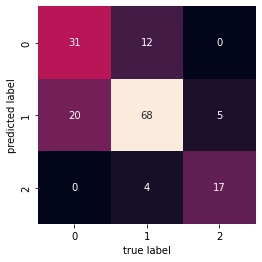

In [27]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.61      0.66        51
           1       0.73      0.81      0.77        84
           2       0.81      0.77      0.79        22

    accuracy                           0.74       157
   macro avg       0.75      0.73      0.74       157
weighted avg       0.74      0.74      0.74       157



In [29]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.7388535031847133, 'train-accuracy': 0.7756410256410257}, params={}, tags={'mlflow.runName': '3_XTree_noCDR_scaled',
 'mlflow.source.git.commit': 'fec7fbc79a3ffae3b9c9fb784985cfd3a66b9538',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/a2aebad9d08a4e4ea9cb08c7d07dd0fb/artifacts', end_time=1661862252783, experiment_id='56', lifecycle_stage='active', run_id='a2aebad9d08a4e4ea9cb08c7d07dd0fb', run_uuid='a2aebad9d08a4e4ea9cb08c7d07dd0fb', start_time=1661862247885, status='FINISHED', user_id='tamarapallien'>>

We see that all our models perform much worse without the CDR. I will try to predict the missing values in the original dataframe, to not lose that many entries and see if that improves something. 

In [30]:
# Load the processed dataset 
df=pd.read_csv('../tadpole_challenge/df_processed.csv')

In [31]:
#We still drop CDR and ID columns but keep all the others 

df.drop(columns=df[['PTID','CDRSB', 'Unnamed: 0']], inplace=True)

In [32]:
df.isnull().sum()

AGE                   2
PTGENDER              0
APOE4               104
FDG                 800
AV45               1146
ABETA               940
TAU                 940
PTAU                940
ADAS11               17
ADAS13               29
MMSE                  0
RAVLT_immediate      17
Ventricles          497
Hippocampus         663
WholeBrain          463
Entorhinal          687
MidTemp             687
DX                   33
dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              2153 non-null   float64
 1   PTGENDER         2155 non-null   object 
 2   APOE4            2051 non-null   float64
 3   FDG              1355 non-null   float64
 4   AV45             1009 non-null   float64
 5   ABETA            1215 non-null   object 
 6   TAU              1215 non-null   object 
 7   PTAU             1215 non-null   object 
 8   ADAS11           2138 non-null   float64
 9   ADAS13           2126 non-null   float64
 10  MMSE             2155 non-null   float64
 11  RAVLT_immediate  2138 non-null   float64
 12  Ventricles       1658 non-null   float64
 13  Hippocampus      1492 non-null   float64
 14  WholeBrain       1692 non-null   float64
 15  Entorhinal       1468 non-null   float64
 16  MidTemp          1468 non-null   float64
 17  DX            

In [34]:
df["PTAU"].replace("<8",np.nan, inplace=True)
df["PTAU"].replace(">120",np.nan, inplace=True)
df["ABETA"].replace("<200",np.nan, inplace=True)
df["ABETA"].replace(">1700",np.nan, inplace=True)
df["TAU"].replace("<80",np.nan, inplace=True)
df["TAU"].replace(">1300",np.nan, inplace=True)

In [35]:
#Convert everything to numerical values 
df[['TAU', 'ABETA', 'PTAU', 'APOE4']].astype(float)

,TAU,ABETA,PTAU,APOE4
0,NaN,NaN,NaN,0.0
1,239.7,741.5,22.83,1.0
2,153.1,1501.0,13.29,0.0
3,337.0,547.3,33.43,0.0
4,NaN,NaN,NaN,0.0
...,...,...,...,...
2150,NaN,NaN,NaN,NaN
2151,NaN,NaN,NaN,NaN
2152,NaN,NaN,NaN,NaN
2153,NaN,NaN,NaN,NaN


In [36]:
#Convert the entries in DX into 0-2 values 
def replace_dx(df, feature):
    df[feature] = df[feature].replace('CN', 0)
    df[feature] = df[feature].replace('MCI', 1)
    df[feature] = df[feature].replace('Dementia', 2)
    return df

col_pass = ['DX']

for col in col_pass: 
    df = replace_dx(df, col)

In [37]:
#Drop the rows in DX that are empty because Python can not work with missing values in the target column 
df.dropna(subset=["DX"], inplace=True)

In [38]:
df=pd.get_dummies(df, columns=['PTGENDER'], drop_first=False)

In [39]:
#Train test split for the df_brain dataframe to avoid data leakage into our test set 
X= df.drop('DX', axis=1)
y=df['DX']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

In [40]:
#Use the KNN imputer to fill the other missing values in the X_train and apply this to X_test 
#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

columns=X_train.columns

# transform X_train und X_test
X_train = pd.DataFrame(imputer.transform(X_train), columns=columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=columns)

In [41]:
print("Missing in train:")
print(X_train.isnull().sum())
print("====================")
print("Missing in test:")
print(X_test.isnull().sum())

Missing in train:
AGE                0
APOE4              0
FDG                0
AV45               0
ABETA              0
TAU                0
PTAU               0
ADAS11             0
ADAS13             0
MMSE               0
RAVLT_immediate    0
Ventricles         0
Hippocampus        0
WholeBrain         0
Entorhinal         0
MidTemp            0
PTGENDER_Female    0
PTGENDER_Male      0
dtype: int64
Missing in test:
AGE                0
APOE4              0
FDG                0
AV45               0
ABETA              0
TAU                0
PTAU               0
ADAS11             0
ADAS13             0
MMSE               0
RAVLT_immediate    0
Ventricles         0
Hippocampus        0
WholeBrain         0
Entorhinal         0
MidTemp            0
PTGENDER_Female    0
PTGENDER_Male      0
dtype: int64


In [42]:
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [43]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='4_XTree_noCDR_trans_scaled')
run = mlflow.active_run()

In [44]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.699 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.748 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.726 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.761 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.723 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.711 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.755 total time=   0.1s[

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 200}

In [45]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [46]:
# Check out the metrics
acc_test = accuracy_score(y_test, y_pred_tuned)
print(acc_test)
acc_train=accuracy_score(y_train, best_model.predict(X_train_scaled))
print(acc_train)

0.7419962335216572
0.7837837837837838


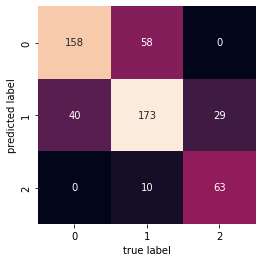

In [47]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [49]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76       198
         1.0       0.71      0.72      0.72       241
         2.0       0.86      0.68      0.76        92

    accuracy                           0.74       531
   macro avg       0.77      0.73      0.75       531
weighted avg       0.75      0.74      0.74       531



In [50]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.7419962335216572, 'train-accuracy': 0.7837837837837838}, params={}, tags={'mlflow.runName': '4_XTree_noCDR_trans_scaled',
 'mlflow.source.git.commit': 'fec7fbc79a3ffae3b9c9fb784985cfd3a66b9538',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/9164292ffde247c58f598b1502e074dc/artifacts', end_time=1661862367401, experiment_id='56', lifecycle_stage='active', run_id='9164292ffde247c58f598b1502e074dc', run_uuid='9164292ffde247c58f598b1502e074dc', start_time=1661862254254, status='FINISHED', user_id='tamarapallien'>>